# Stain Detection Algorithm - Rachsaw

## Importing the header files

In [27]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math

## Reading the Image

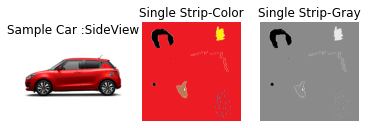

In [28]:
sample = cv2.imread('side_red_1.png')
img_color = cv2.imread('Side_Sample_1.png')
img = cv2.imread('Side_Sample_1.png',0)
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)),plt.title("Sample Car :SideView"),plt.axis("off")
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)),plt.title("Single Strip-Color"),plt.axis("off")
ax2 = fig.add_subplot(1,3,3)
ax2.imshow(img,cmap='gray'),plt.title("Single Strip-Gray"),plt.axis("off")
plt.show()   

## Thresholding the image

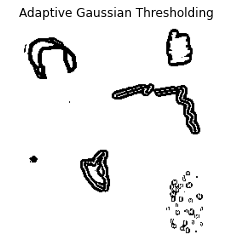

In [29]:
thr = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
plt.imshow(thr,cmap='gray'),plt.title('Adaptive Gaussian Thresholding'),plt.axis("off")
plt.show()

## Detecting the contour lines and bounding them by rectangles

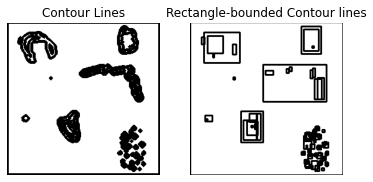

In [30]:
area_thr = 1
contours, hierarchy = cv2.findContours(thr,cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
area = []
r = []
for idx, contour in enumerate(contours):
        if (cv2.contourArea(contour) > area_thr):
            area.append(cv2.contourArea(contour))
            r.append(cv2.boundingRect(contours[idx]))
#print(area)

blank = np.zeros(list(np.shape(img)),dtype=np.uint8)
blank.fill(255)

cntr = cv2.drawContours(blank, contours, -1, (0,255,0), 3)

blank1 = np.zeros(list(np.shape(img)),dtype=np.uint8)
blank1.fill(255)
for x,y,w,h in r:
    cntr_final = cv2.rectangle(blank1, (x,y), (x+w,y+h), (0,0,0), 2)
    
#print(r)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cntr,cmap='gray'),plt.title("Contour Lines"),plt.axis("off")
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(cntr_final,cmap='gray'),plt.title("Rectangle-bounded Contour lines"),plt.axis("off")
plt.show()  

## Grouping close stains together to form clusters

In [31]:
r_mp = []

for x,y,w,h in r:
    r_mp.append([(x+w)/2,(y+h)/2])

#print(r_mp)
#print(len(r_mp))

r_thr = 20
r_close = []

for i in range(len(r_mp)):
    for j in range(i+1,len(r_mp)):
        if math.dist(r_mp[i],r_mp[j])<r_thr:
            r_close.append([i,j])

In [32]:
sets = []
k=0
for i in range(r_close[-1][0]+1):
    cluster = []
    for i,j in r_close:
        if i==k:
            cluster.append(j)
            cluster.append(i)
    if len(cluster)!=0 :
        sets.append(set(cluster))
    k+=1
#print(sets)

i=0
for seti in sets :
    i=i+1
    for setj in sets[i:] :
        if len(seti & setj) != 0 and seti != setj:
            seti = seti | setj
            sets.remove(setj)
#print(sets)

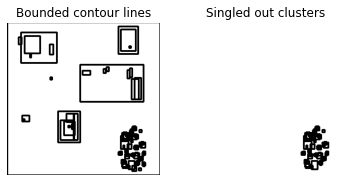

In [33]:
blank2 = np.zeros(list(np.shape(img)),dtype=np.uint8)
blank2.fill(255)
for i in sets[0]:
    clusters = cv2.rectangle(blank2, (r[i][0],r[i][1]) , (r[i][0]+r[i][2],r[i][1]+r[i][3]), (0,0,0), 2)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cntr_final,cmap='gray'),plt.title("Bounded contour lines"),plt.axis("off")
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(clusters,cmap='gray'),plt.title("Singled out clusters"),plt.axis("off")
plt.show()  


## Bounding the clusters and forming groups

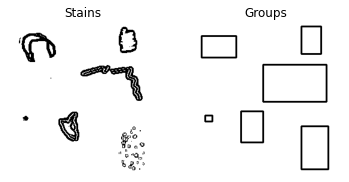

In [34]:
loct = []

for seti in sets:
    x_max=0
    y_max=0
    x_min=256
    y_min=256
    for i in seti:
        x,y,w,h = r[i]
        if x < x_min:
            x_min = x
        if x + w > x_max:
            x_max = x+w
        if y < y_min:
            y_min = y
        if y + h > y_max:
            y_max = y+h
    loct.append([x_min,y_min,x_max,y_max])

for m in loct:
    for M in loct:
        if m!=M and M[0]>m[0] and M[1]>m[1] and M[2]<m[2] and M[3]<m[3]:
            loct.remove(M)
    
    
blank5 = np.zeros(list(np.shape(img)),dtype=np.uint8)
blank5.fill(255)

for x1,y1,x2,y2 in loct:
    groups = cv2.rectangle(blank5, (x1,y1) , (x2,y2), (0,0,0), 2)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(thr,cmap='gray'),plt.title("Stains"),plt.axis("off")
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(groups,cmap='gray'),plt.title("Groups"),plt.axis("off")
plt.show()


## Displaying the detected stains

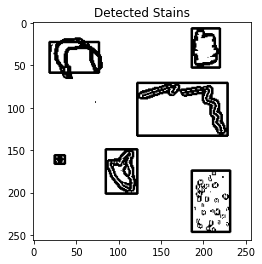

In [35]:
thr1 = thr
loct_final = []
for x1,y1,x2,y2 in loct:
    stains = cv2.rectangle(thr1, (x1,y1) , (x2,y2), (0,0,0), 2)
    loct_final.append([(x1+x2)/2,(y1+y2)/2,(x2-x1)*(y2-y1)])

plt.imshow(stains,cmap='gray'),plt.title("Detected Stains")
plt.show()

#cv2.imwrite("result_3.jpg",stains)

## Output the location and size of stains

In [36]:
print(loct_final)

area_groups = []

for x1,y1,x2,y2 in loct:
    area_groups.append((x2-x1)*(y2-y1))
    
#print(area_groups)
perc = (sum(area_groups)/np.size(stains) )* 100
print("Percentage of stains : ", perc)

[[208.5, 210.0, 3240], [103.5, 175.0, 1924], [175.0, 102.0, 6572], [48.0, 41.0, 2088], [202.5, 30.0, 1518], [31.0, 161.0, 120]]
Percentage of stains :  23.5931396484375
